# Text Analytics Project

## Task A

In [1]:
#!pip install spacy

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import MDS
import re
import spacy
import spacy.cli
from spacy.lang.en import stop_words
spacy.cli.download("en_core_web_sm")
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.corpus import stopwords
from nltk import bigrams
stopwords_set = set(stopwords.words('english'))
characterstoclean = r'?!,:./\"-+=@#$%^&*()><{}[]|' + r"'"
import re

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Documents
doc = pd.read_csv('edmunds_extraction.csv')
doc['message'].fillna('', inplace=True)

In [4]:
# Clean Text
nlp = spacy.load('en_core_web_sm')
def clean_text(x): # x is a document
    # conver to lower case 
    x = x.lower()
    # remove new line
    x = re.sub(r'\n', ' ', x)
    # remove link
    x = re.sub(r"https?://[^\s]+", "", x)
    # remove name twitter tag
    x = re.sub(r'@[A-Za-z0-9\_]+', ' ', x) 
    # remove name hashtag tag
    x = re.sub(r'\#[A-Za-z0-9\_]+', ' ', x) 
    # remove specific word - southwest OR airline
    x = re.sub('southwest|airline', ' ', x)
    # lemmatization
    x = ' '.join([token.lemma_ for token in nlp(x)])
    # remove multiple space
    x = re.sub(r' +', ' ', x)
    # remove space before and after the text
    x = x.strip()
    return x

↑ airline? we might need to fix this to our case

In [5]:
# Convert documents into a list
all_documents = doc['message'].tolist()

In [6]:
# List of non-brand words to exclude
exclude_words = ['problem', 'car', 'seat', 'engine', 'wheel', 'door', 'window', 'suv', 'sedan', 'vehicle', 'mpv', 'hatchback', 'crossover', 'convertible', 'coupe', 'truck', 'van', 'roadster', 'cabriolet', 'sportscar']

# Read the list of car brands/models from the CSV file
models = pd.read_csv('models.csv', header=None)


In [7]:
# Clean the model's brand column 
# Define a function to clean the data
def clean_data(value):
    if isinstance(value, str):
        # Remove unwanted characters
        value = value.replace(",", "").replace(".", "")
    return value

# Clean the first and second columns
models[0] = models[0].apply(clean_data)
models[1] = models[1].apply(clean_data)

↑ clean instances like kia, kia. and kia,.

In [8]:
models.shape

(528, 2)

In [9]:
# Create a boolean mask
mask = ~models[0].isin(exclude_words)

# Apply the mask to filter the DataFrame
filtered_models = models[mask]
filtered_models.shape

(524, 2)

↑ removed 4 rows

In [10]:
# lower case
all_documents = [doc.lower() for doc in all_documents]
filtered_models[1] = filtered_models[1].str.lower()
filtered_models[0] = filtered_models[0].str.lower()

In [11]:
filtered_models[1]

0      integra
1       legend
2        vigor
3          rlx
4          ilx
        ...   
523       xc90
524        s60
525        s80
526        v60
527        c70
Name: 1, Length: 524, dtype: object

#### Conver the model name into a list

In [12]:
# Create a mapping dictionary from Model to Brand
model_to_brand = pd.Series(filtered_models[0].values, index=filtered_models[1]).to_dict()

def replace_models_with_brands(text):
    for model, brand in model_to_brand.items():
        text = re.sub(r'\b' + re.escape(model) + r'\b', brand, text)
    return text

# Replace in all_documents
all_documents = [replace_models_with_brands(doc) for doc in all_documents]

In [13]:
# # save as text
# with open('all_documents.txt', 'w') as f:
#     for item in all_documents:
#         f.write("%s\n" % item)

↑ this is to check if the model name is replaced by brand name

In [14]:
# model_names = filtered_models[1].tolist()   

In [15]:
car_brands = filtered_models[0].unique().tolist()

In [16]:
# Define a custom tokenizer function
def unique_tokenizer(text):
    # Apply the clean_text function first (assuming it's already defined)
    text = clean_text(text)
    # Use a set to store unique tokens
    tokens = set(re.findall('[a-zA-Z0-9]{3,}', text))
    return list(tokens)

# # Create an instance of CountVectorizer with the custom tokenizer
# vectorizer = CountVectorizer(vocabulary=car_brands,
#                              max_features=10,
#                              tokenizer=unique_tokenizer,
#                              token_pattern='[a-zA-Z0-9]{3,}')

# # Example data
# test = ['BMW, BMW, FORD, FORD']
# 
# # Transform the data
# dtm = vectorizer.fit_transform(test)

In [17]:
# feature_names = vectorizer.get_feature_names_out()
# 
# # Convert the document-term matrix to a dense array
# dtm_array = dtm.toarray()
# print(feature_names)
# print(dtm_array)

↑ **Here you can see that bmw and ford is counted only once despite they appear twice in the text**

In [18]:
# Initialize the CountVectorizer to transform the text data into a bag-of-words model only for the top 10 most frequent non-stopwords, do the MDS for those words
# Create an instance of CountVectorizer with the custom tokenizer

vectorizer = CountVectorizer(vocabulary=car_brands,
                             max_features=10,
                             tokenizer=unique_tokenizer,
                             token_pattern='[a-zA-Z0-9]{3,}')


In [19]:
# Transform the documents into a document-term matrix
dtm = vectorizer.fit_transform(all_documents)

# Extract feature names (non-stopwords)
feature_names = vectorizer.get_feature_names_out()

# Convert the document-term matrix to a dense array
dtm_array = dtm.toarray()

# Calculate lift between terms
term_lift = np.dot(dtm_array.T, dtm_array)
term_occurrence = np.sum(dtm_array, axis=0)

# Recheck for brands with zero occurrences and handle them
zero_occurrence_indices = np.where(term_occurrence == 0)[0]
if len(zero_occurrence_indices) > 0:
    for idx in zero_occurrence_indices:
        print(f"Brand '{feature_names[idx]}' is not mentioned and will be excluded from MDS analysis.")
    # Exclude brands with zero occurrences
    valid_indices = np.setdiff1d(np.arange(len(feature_names)), zero_occurrence_indices)
    dtm_array = dtm_array[:, valid_indices]
    term_lift = term_lift[valid_indices][:, valid_indices]
    term_occurrence = term_occurrence[valid_indices]
    feature_names = [feature_names[i] for i in valid_indices]

# Select indices of top 10 most frequent brands
top_10_indices = np.argsort(term_occurrence)[-10:]

# Filter DTM and feature names for top 10 brands
dtm_array = dtm.toarray()[:, top_10_indices]
feature_names = [feature_names[i] for i in top_10_indices]
    
# Add a small constant to avoid division by zero and calculate lift matrix
constant = 1e-8
lift_matrix = np.zeros((len(feature_names), len(feature_names)))
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        if term_occurrence[i] * term_occurrence[j] > 0:
            lift_matrix[i, j] = term_lift[i, j] / (term_occurrence[i] * term_occurrence[j] + constant)
        else:
            lift_matrix[i, j] = 0  # Set lift to 0 if either term does not occur

# Calculate dissimilarity matrix based on lift
dissimilarity_matrix = np.where(lift_matrix != 0, 1 / lift_matrix, 0)
print(dissimilarity_matrix)

Brand 'hyndai kia' is not mentioned and will be excluded from MDS analysis.
Brand 'toyata' is not mentioned and will be excluded from MDS analysis.
Brand 'volkwagen' is not mentioned and will be excluded from MDS analysis.
[[   76.          1672.           957.6         1621.33333334
      0.          4195.2         9462.00000001     0.
   5724.          2740.98360656]
 [ 1672.            44.           693.          1408.
    469.33333334  6072.00000001     0.          3608.00000001
   6996.          5094.73684211]
 [  957.6          693.           126.          2016.
   1008.          3864.          4482.         10332.00000001
   7212.24        4544.26229508]
 [ 1621.33333334  1408.          2016.            64.
    292.57142857   706.56        2276.57142857  1312.
   3816.          4855.17241379]
 [    0.           469.33333334  1008.           292.57142857
     32.           883.2         3984.00000001     0.
   9158.4         7822.22222222]
 [ 4195.2         6072.00000001  3864.  

In [20]:
print("Top 10 brands by frecuency: ", feature_names)

Top 10 brands by frecuency:  ['subaru', 'chrysler', 'saturn', 'chevrolet', 'nissan', 'mazda', 'hyundai', 'toyota', 'ford', 'honda']


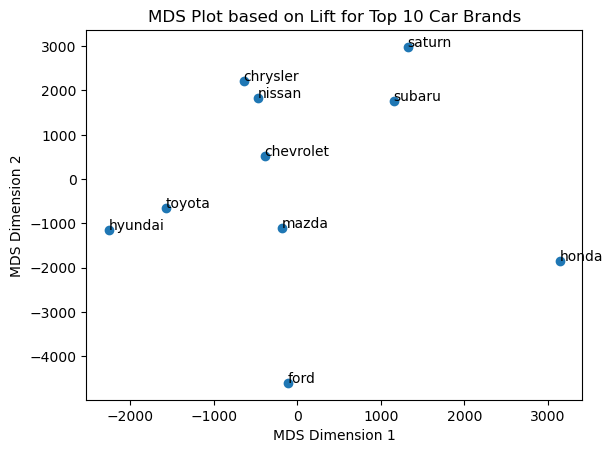

In [21]:
# Apply MDS to reduce dimensionality to 2D
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_result = mds.fit_transform(dissimilarity_matrix)

# Plot the MDS result
plt.scatter(mds_result[:, 0], mds_result[:, 1])

# Annotate points with feature names
for i, txt in enumerate(feature_names):
    plt.annotate(txt, (mds_result[i, 0], mds_result[i, 1]))

plt.title('MDS Plot based on Lift for Top 10 Car Brands')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.show()

## Task B

### Honda:
Positioning: Honda is positioned at the far right of the MDS Dimension 1, which suggests a significant differentiation from most other car brands in the dataset. This could indicate a unique selling proposition (USP) that Honda possesses, setting it apart in the discussions or perceptions among consumers.

Brand Strengths: Honda's outlier position could be reflective of strong brand associations with specific attributes, such as reliability, engineering, or value for money. The fact that it is far removed from the cluster of other brands may suggest that it owns a particular niche or that its brand is not commonly confused with others.

Consumer Perception and Strategy: Given Honda's distinctive placement, the company could leverage this in their marketing strategy by emphasizing the qualities that lead to this separation. If the attributes are positive, Honda should reinforce these in communication. If there are negative connotations, Honda might need to address these in order to move closer to the cluster, if that is desirable.

### Subaru:
Positioning: Subaru is positioned towards the upper right quadrant, but closer to the center of the plot compared to Honda. This indicates that Subaru shares some commonalities with other brands, especially Chevrolet, but still retains a level of distinctiveness in some aspects.

Niche Market Appeal: Subaru’s position may reflect its reputation for producing vehicles that are robust, suitable for off-road and all-weather conditions, appealing to a niche market that values these characteristics. Their position suggests that they are recognized for this niche, but not as strongly separated as Honda, indicating potential overlap with other brands in certain aspects.

Marketing Implications: Subaru could focus on strengthening its unique brand elements that appeal to its niche market. At the same time, it could explore what attributes shared with brands like Chevrolet contribute to its positioning and decide whether to emphasize or differentiate from these in future strategies.

**For both Honda and Subaru, the insights suggest different strategic approaches. Honda may benefit from capitalizing on and reinforcing its distinct brand positioning, while Subaru could explore the dual strategy of niche market reinforcement and investigation into shared attributes with other brands for potential opportunities. It is critical for both brands to delve into the qualitative aspects behind their positioning to fully understand the drivers of their brand perception and strategize accordingly.**

## Task C

In [22]:
combined_sentences=doc['message'].str.cat(sep=' ')
wordlist=word_tokenize(combined_sentences)

We first checked the occurance of tokenized words to get a general idea of what attribues are mentioned in the forum.

In [23]:
lemmatizer = WordNetLemmatizer()
lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in wordlist]
result_string = " ".join(lemmatized_words)

In [24]:
ranked_cnt = []
for word in lemmatized_words:
    if word not in stopwords_set and word not in characterstoclean:
        ranked_cnt.append(word)

In [25]:
def count_and_rank_words(word_list):
    # Count the frequency of each word
    word_counts = Counter(word_list)

    # Rank the words in descending order based on frequency
    ranked_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    return ranked_words

result = count_and_rank_words(ranked_cnt)

# Display the result
for word, count in result:
    print(f"{word}: {count}")

car: 5260
n't: 4125
's: 3538
accord: 3092
wa: 2778
would: 2252
``: 2237
'': 2079
like: 2015
one: 1811
ha: 1724
fusion: 1617
year: 1614
get: 1481
think: 1459
honda: 1370
new: 1257
ford: 1249
good: 1237
v6: 1144
doe: 1126
...: 1118
engine: 1098
time: 1071
much: 1068
better: 1021
camry: 960
make: 942
even: 940
well: 935
look: 887
also: 862
mile: 847
thing: 843
know: 839
--: 811
see: 798
'm: 780
price: 773
vehicle: 761
say: 757
sonata: 752
people: 742
really: 736
le: 733
model: 717
way: 713
drive: 691
could: 689
sedan: 664
go: 661
lot: 632
still: 631
6: 623
many: 618
sale: 617
going: 607
want: 606
've: 601
cost: 590
buy: 589
altima: 583
need: 578
value: 574
right: 547
something: 540
toyota: 538
4: 535
back: 531
driving: 526
best: 516
mazda6: 512
power: 512
mpg: 498
may: 495
problem: 493
last: 488
'd: 478
take: 476
since: 473
sure: 468
great: 457
never: 455
old: 454
though: 448
interior: 448
difference: 443
mazda: 442
maybe: 442
dealer: 442
got: 434
;: 433
ca: 430
'll: 426
come: 426
actuall

Based on the occurance result, we generated a dictionary to group different words into attributes.

In [26]:
car_attributes_dict = {
    'performance':['engine','power','speed','control','handling','transmission','performance','rear','brake','cylinder','mph','stop','0-60','torque','gear','steering','rpm','cvt','acceleration', 'speed', 'power', 'torque', 'horsepower', 'hp', 'efficient', 'agile','pickup', '0-60', 'handling', 'dynamics', 'throttle', 'responsive', 'shifting', 'transmission'],
    
    'cost':['price','cost','value','$','money','worth','premium','msrp','expensive','maintenance','discount','cheap','cheaper'],
    
    'design': ['interior','design','styling','mid-size','small','size','large','sport','wagon','huge','mustang','style','rwd','larger','door', 'appearance', 'aesthetics', 'body', 'exterior','adaptable', 'versatile','finish', 'trim', 'paint', 'luxury', 'modern', 'sleek', 'sporty', 'customize', 'personalize', 'tailored','craftsmanship', 'bodywork', 'streamline', 'aerodynamics', 'color'],
    
    'comfort':['seat','seats','family','legroom', 'interior', 'upholstery', 'ride', 'headroom', 'comfort', 'relax', 'spacious', 'plush','cargo','space', 'infotainment', 'air conditioning', 'ac', 'sound', 'quiet', 'adjustment', 'ergonomics', 'soft', 'touch', 'leather', 'heated', 'ventilated', 'lighting'],
    
    'economy':['fuel','gas','economy','oil','diesel','hybird','mileage', 'mpg', 'fuel','efficiency', 'economy', 'range', 'gas consumption', 'hybrid','electric', 'charging','green', 'eco-friendly', 'emission','ownership', 'battery', 'energy', 'consumption'],
    
    'reliability':['quality','reliability','repair','tire','reliable','warranty', 'dependable', 'durable', 'breakdown', 'recall', 'solid','service', 'longevity', 'wear','tear', 'robust', 'long-lasting', 'resilient'],
    
    'technology':['automatic', 'infotainment', 'connectivity', 'bluetooth', 'navigation', 'gps', 'touchscreen', 'smart', 'tech', 'connect', 'automate','app', 'smartphone', 'autopilot','intelligent','tech', 'digital', 'head-up','display', 'telematics', 'remote', 'wireless','charging', 'software'],
    
    'safety':['insurance','safety', 'airbags', 'brakes', 'collision', 'assist', 'lane', 'blind', 'safe', 'sturdy', 'crash', 'abs', 'stability', 'traction', 'reliable','sensors', 'rearview', 'camera', 'emergency', 'braking', 'pedestrian', 'detection', 'alert'],
}

In [27]:
attribute_counts = Counter()
for general_attribute, attribute_words in car_attributes_dict.items():
    for word in lemmatized_words:
        if word in attribute_words:
            # Replace the lemmatized word with the general attribute
            paragraph = result_string.replace(word, general_attribute)
            # Increment the count of the general attribute
            attribute_counts[general_attribute] += 1

In [28]:
for general_attribute, count in attribute_counts.items():
    print(f"{general_attribute}: {count}")

performance: 5636
cost: 4961
design: 2980
comfort: 1927
economy: 2478
reliability: 2015
technology: 370
safety: 953


#### The top 5 most frequently mentioned attributes are: 
- performance, 
- cost, 
- design, 
- comfort, 
- economy.

From previous tasks we know that the top 5 brands by frecuency are 'subaru', 'chrysler', 'saturn', 'chevrolet', 'nissan'.

In [29]:
models.columns = ['brand', 'model']

In [30]:
top_brands = ['subaru', 'chrysler', 'saturn', 'chevrolet', 'nissan']

In [31]:
# Initialize a dictionary to hold the brand and model names
brand_models = {brand: [] for brand in top_brands}

# Populate the dictionary with brand and corresponding models
for index, row in models.iterrows():
    brand = row['brand'].lower()  # Ensure the brand name is in lowercase
    model = row['model'].lower()  # Ensure the model name is in lowercase
    if brand in brand_models:
        brand_models[brand].append(model)

In [32]:
# Initialize counters
brand_model_counts = Counter()
attribute_counts = Counter()

# Initialize brand_model_attribute_counts to include both brands and models
brand_model_attribute_counts = {}
for brand, models in brand_models.items():
    brand_model_attribute_counts[brand] = Counter()
    for model in models:
        brand_model_attribute_counts[model] = Counter()  # Include models
        
sentences = sent_tokenize(doc['message'].str.cat(sep=' ').lower())

# Adjust the counting and analysis to include models
for sentence in sentences:
    words = word_tokenize(sentence)
    for brand, models in brand_models.items():
        # Check for both brand and model mentions
        if brand in words or any(model in words for model in models):
            brand_model_counts[brand] += 1  # Count the brand mention
            for general_attribute, attribute_words in car_attributes_dict.items():
                if any(attribute_word in words for attribute_word in attribute_words):
                    attribute_counts[general_attribute] += 1
                    brand_model_attribute_counts[brand][general_attribute] += 1
                    # Optionally, count model-specific mentions
                    for model in models:
                        if model in words:
                            brand_model_attribute_counts[model][general_attribute] += 1
                            brand_model_counts[model] += 1           
                            
# Sum model counts into their respective brands
for brand, models in brand_models.items():
    for model in models:
        brand_model_attribute_counts[brand] += brand_model_attribute_counts[model]

# Display the results for brands only
for brand in top_brands:
    print(f"Brand: {brand}")
    for attribute, count in brand_model_attribute_counts[brand].most_common():
        print(f"  {attribute}: {count}")

Brand: subaru
  design: 86
  performance: 64
  comfort: 46
  cost: 26
  safety: 18
  reliability: 17
  economy: 12
  technology: 2
Brand: chrysler
  cost: 92
  design: 68
  performance: 64
  reliability: 50
  comfort: 49
  economy: 26
  safety: 19
  technology: 12
Brand: saturn
  performance: 84
  cost: 75
  design: 71
  comfort: 43
  economy: 11
  reliability: 10
  safety: 6
  technology: 6
Brand: chevrolet
  design: 331
  performance: 231
  cost: 226
  economy: 148
  comfort: 111
  reliability: 33
  safety: 31
  technology: 20
Brand: nissan
  performance: 323
  design: 183
  cost: 140
  comfort: 118
  economy: 101
  safety: 51
  reliability: 49
  technology: 20


In [33]:
# Initialize total_brand_attribute_counts to hold the combined attribute counts for each brand and its models
total_brand_attribute_counts = {brand: Counter() for brand in top_brands}

for brand in top_brands:
    # Sum attribute counts for the brand and its models
    for attribute in car_attributes_dict:
        total_brand_attribute_counts[brand][attribute] = sum(brand_model_attribute_counts[brand_model][attribute] for brand_model in [brand] + brand_models[brand])

# Calculate the total number of sentences
total_sentences = len(sentences)

# Initialize total_brand_counts to hold the combined counts for each brand and its models
total_brand_counts = {brand: sum(brand_model_counts[brand_model] for brand_model in [brand] + brand_models[brand]) for brand in top_brands}

# Calculate lift values and find the attribute with the highest lift for each brand
highest_lift_attributes = {}
for brand in top_brands:
    highest_lift = 0
    most_associated_attribute = None
    for attribute in car_attributes_dict:
        # Ensure the attribute is mentioned with the brand
        if total_brand_attribute_counts[brand][attribute] > 0:
            numerator = (total_brand_attribute_counts[brand][attribute] / total_sentences)
            denominator = (total_brand_counts[brand] / total_sentences) * (attribute_counts[attribute] / total_sentences)

            # Avoid division by zero
            lift = numerator / denominator if denominator > 0 else 0

            if lift > highest_lift:
                highest_lift = lift
                most_associated_attribute = attribute

    highest_lift_attributes[brand] = most_associated_attribute

# Display the most strongly associated attribute for each brand
for brand, attribute in highest_lift_attributes.items():
    print(f"Brand: {brand}, Most Strongly Associated Attribute: {attribute}")

Brand: subaru, Most Strongly Associated Attribute: design
Brand: chrysler, Most Strongly Associated Attribute: reliability
Brand: saturn, Most Strongly Associated Attribute: cost
Brand: chevrolet, Most Strongly Associated Attribute: economy
Brand: nissan, Most Strongly Associated Attribute: performance


In [34]:
# Initialize lift_values to hold the lift values for each brand
lift_values = {brand: {} for brand in top_brands}
attribute_total_lift = Counter()

# Calculate lift values considering both brands and their models
for brand in top_brands:
    # Calculate the total counts for the brand, including its models
    total_brand_count = sum(brand_model_counts[brand_model] for brand_model in [brand] + brand_models[brand])
    
    for attribute in car_attributes_dict:
        # Calculate the total attribute count for the brand, including its models
        total_attribute_count = sum(brand_model_attribute_counts[brand_model][attribute] for brand_model in [brand] + brand_models[brand])
        
        numerator = (total_attribute_count / total_sentences)
        denominator = (total_brand_count / total_sentences) * (attribute_counts[attribute] / total_sentences)
        
        # Avoid division by zero
        lift = numerator / denominator if denominator > 0 else 0
        lift_values[brand][attribute] = lift
        
        # Sum lift values for each attribute across the top 5 brands
        attribute_total_lift[attribute] += lift

# Find the attribute with the highest total lift across the top 5 brands
most_associated_attribute = attribute_total_lift.most_common(1)[0]

# Display the result
print(f"Attribute Most Strongly Associated with Top 5 Brands: {most_associated_attribute[0]} ")

Attribute Most Strongly Associated with Top 5 Brands: design 


## Task D

### Subaru
Subaru is highly recognized in performance and design, signaling a need for product managers to elevate these key attributes further. The brand's strong ties to comfort and safety resonate with a loyal customer base, prioritizing reliability and security. Marketing should emphasize these strengths, appealing to families and safety-conscious drivers. Incorporating cost-effectiveness and fuel efficiency into Subaru's narrative can broaden its market appeal, presenting the brand's commitment to providing value without compromising on quality.
### Chrysler
Chrysler stands out for its reliability, economy, and performance. Product managers should focus on enhancing the brand's reputation for reliability through quality craftsmanship and extended warranties. The balance between economy and performance should be emphasized in product development. Marketing efforts should underline the reliability and cost-effectiveness of Chrysler vehicles, targeting buyers who value long-term investment and reliability in their purchases.

### Chevrolet
Chevrolet is predominantly associated with economy. Product managers should concentrate on fuel efficiency and cost-effective solutions in Chevrolet's vehicle lineup. Marketing campaigns should focus on the economic benefits of Chevrolet vehicles, highlighting fuel efficiency and low maintenance costs to attract cost-conscious consumers and those looking for economical and eco-friendly vehicles.

### Saturn
Saturn is recognized for its cost efficiency while maintaining commendable performance and design. Product managers should ensure that Saturn vehicles offer competitive pricing without compromising on quality and performance. Marketing strategies should emphasize the brand's value proposition, showcasing how Saturn offers a balance between affordability, performance, and aesthetic appeal, catering to budget-conscious consumers who still value a quality driving experience.

### Nissan
Nissan excels in performance, making it the brand's most distinct attribute. Product managers should continue to innovate in areas that enhance the vehicle's performance, including speed, handling, and overall driving dynamics. Marketing efforts should put performance in the spotlight, showcasing Nissan's superior driving experience, appealing to car enthusiasts and consumers who prioritize a dynamic and powerful driving experience.

## Task E

In [35]:
def create_bigrams(text):
    # Lowercasing
    text = str(text).lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    words = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lm = []
    for w in words:
        lm.append(lemmatizer.lemmatize(w))
    # Create bigrams
    return list(bigrams(lm))

# Apply the function to your comments
doc['Bigram list'] = doc['message'].map(create_bigrams)

doc['Bigram list']

0       [(hi, pat), (pat, you), (you, forgot), (forgot...
1       [(im, sure), (sure, some), (some, folk), (folk...
2       [(you, can), (can, try), (try, to), (to, reviv...
3       [(model, v), (v, model), (model, is), (is, exa...
4       [(the, altima), (altima, is), (is, my), (my, f...
                              ...                        
5095    [(your, post), (post, make), (make, no), (no, ...
5096    [(that, is), (is, smart), (smart, of), (of, fo...
5097    [(care, to), (to, back), (back, that), (that, ...
5098    [(i, think), (think, if), (if, all), (all, man...
5099    [(chrysler, only), (only, make), (make, two), ...
Name: Bigram list, Length: 5100, dtype: object

In [36]:
aspir_list = [('love', 'to'),
('would', 'love'),
('would', 'hope'),
('hope', 'to'),
('wish', 'to'),
('wish', 'that'),
('wish', 'for'),
('wishing', 'for'),
('want', 'to'),
('wants', 'to'),
('dream', 'of'),
('daydreaming', 'about'),
('dream', 'to'),
('desire', 'for'),
('desire', 'to'),
('everyone', 'desires'),
('future', 'car'),
('near', 'future'),
('future', 'vehicle'),
('to', 'buy'),
('buy', 'the'),
('buy', 'it'),
('can', 'buy'),
('would', 'buy'),
('will', 'buy'),
('will', 'buy'),
('could', 'buy'),
('buy', 'cars'),
('buy', 'new'),
('may', 'buy'),
('to', 'purchase'),
('purchase', 'the'),
('purchase', 'it'),
('purchase', 'cars'),
('possible', 'purchase'),
('will', 'purchase'),
('next', 'purchase'),
('like', 'to'),
('will', 'get'),
('could', 'get'),
('i', 'wish'),
('can', 'get'),
('i','want'),
('stick','with'),
             ("hope", "to"),
    ("dream", "of"),
    ("wish", "to"),
    ("looking", "forward"),
    ("saving", "for"),
    ("eager", "to"),
    ("excited", "about"),
    ("enthusiastic", "about"),
    ("keen", "on"),
    ("set", "on"),
    ("fixated", "on"),
    ("focused", "on"),
    ("determined", "to"),
    ("committed", "to"),
    ("dedicated", "to"),
    ("can't", "wait"),
    ("longing", "for"),
    ("yearning", "for"),
    ("itching", "for"),
    ("dying", "for"),
    ("dreaming", "of"),
    ("thinking", "of"),
    ("considering", "buying"),
    ("planning", "to"),
    ("aiming", "to"),
    ("hoping", "to"),
    ("wishing", "for"),
    ("desiring", "to"),
    ("craving", "for"),
    ("praying", "for"),
    ("envision", "driving"),
    ("fantasize", "about"),
    ("visualize", "driving"),
    ("imagine", "driving"),
    ("contemplating", "getting")]

In [37]:
def has_aspirational_bigram(bigram_list):
    if any(bigram in aspir_list for bigram in bigram_list):
        return 1
    return 0

# Apply the function to find comments with aspirational bigrams
doc['is_aspirational'] = doc['Bigram list'].apply(has_aspirational_bigram)

In [38]:
doc['is_aspirational'].value_counts()
doc.iloc[ :, -1:].columns.values

array(['is_aspirational'], dtype=object)

In [39]:
aspirations = doc.iloc[ :, -1:].columns.values
aspr_matrix = pd.DataFrame(index=feature_names, columns=aspirations)

In [40]:
from nltk.tokenize import word_tokenize
def tokenize_comment(text):
    text = str(text).lower()
    return word_tokenize(text)

# Apply tokenization to the comment column
doc['message_tokens'] = doc['message'].apply(tokenize_comment)
for brand in feature_names:
    doc[brand] = doc['message_tokens'].map(lambda x: 1 if brand in x else 0)

In [41]:
doc['is_aspirational'].value_counts()

is_aspirational
0    4270
1     830
Name: count, dtype: int64

In [42]:
for brand in feature_names:
    freq_brand = doc[brand].sum()
    freq_aspr = doc['is_aspirational'].sum()
    freq_both = doc["is_aspirational"][(doc[brand] == 1) & (doc['is_aspirational'] == 1 )].sum()
    lift = len(doc) * freq_both / (freq_brand * freq_aspr)
    aspr_matrix.loc[brand] = lift
    

aspr_matrix.sort_values(by = 'is_aspirational', ascending= False)

,is_aspirational
chevrolet,2.048193
mazda,1.481104
subaru,1.455295
saturn,1.428972
toyota,1.235418
chrysler,1.228916
hyundai,1.17954
ford,1.168395
honda,1.140651
nissan,0.873637
